[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/arvidl/ELMED219-2026/blob/main/Lab3-GenAI-LLM/notebooks/05-xai-forklarbar-ai.ipynb)

# Forklarbar AI (XAI) i Medisin

**ELMED219 / BMED365 - Lab 3**

---

## Læringsmål

Etter denne notebooken skal du kunne:
- Forklare hvorfor forklarbarhet er viktig i medisinsk AI
- Beskrive ulike XAI-metoder (SHAP, LIME, attention)
- Vurdere styrker og svakheter ved ulike forklaringsmetoder
- Diskutere kliniske krav til AI-tolkbarhet

## Innhold

1. [Hvorfor forklarbar AI?](#1-hvorfor-forklarbar-ai)
2. [Typer forklarbarhet](#2-typer-forklarbarhet)
3. [SHAP - SHapley Additive exPlanations](#3-shap)
4. [LIME - Local Interpretable Model-agnostic Explanations](#4-lime)
5. [Attention-baserte forklaringer](#5-attention-baserte-forklaringer)
6. [Kliniske krav og utfordringer](#6-kliniske-krav-og-utfordringer)

---

## 1. Hvorfor forklarbar AI?

I helsevesenet er det ikke nok at AI gir riktig svar - vi må også forstå **hvorfor**.

### Grunner til at XAI er kritisk i medisin

| Grunn | Forklaring |
|-------|------------|
| **Tillit** | Leger må stole på AI-anbefalinger før de handler |
| **Ansvar** | Ved feil må vi forstå hva som gikk galt |
| **Regulering** | EU AI Act krever forklarbarhet for høyrisiko-AI |
| **Læring** | Forklaringer kan avdekke ny medisinsk kunnskap |
| **Feilsøking** | Identifisere bias eller feil i modellen |

### Den sorte boksen

Komplekse modeller som dype nevrale nettverk og LLM-er kalles ofte "sorte bokser" fordi:

```
Input (Pasientdata)  →  [???]  →  Output (Diagnose/Risiko)
         ↓                              ↓
    Vi forstår              Vi ser svaret
    hva som går inn         men ikke HVORFOR
```

XAI-metoder prøver å åpne denne boksen.

In [1]:
# Miljøoppsett
import sys
import numpy as np
import matplotlib.pyplot as plt

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    print("Kjører i Google Colab")
else:
    print("Kjører i lokalt miljø")

print("Klar for XAI-demonstrasjoner!")

Kjører i lokalt miljø
Klar for XAI-demonstrasjoner!


---

## 2. Typer forklarbarhet

### Global vs. Lokal forklarbarhet

| Type | Spørsmål | Eksempel |
|------|----------|----------|
| **Global** | Hvordan fungerer modellen generelt? | "Blodtrykk er viktigste faktor for hjertesykdom" |
| **Lokal** | Hvorfor dette svaret for denne pasienten? | "Denne pasienten fikk høy risiko pga røyking + høyt kolesterol" |

### Ante-hoc vs. Post-hoc

| Type | Når | Eksempel |
|------|-----|----------|
| **Ante-hoc** | Bygget inn i modellen | Beslutningstrær, lineær regresjon |
| **Post-hoc** | Analyserer ferdig modell | SHAP, LIME, GradCAM |

In [2]:
# Eksempel: Enkel tolkbar modell vs. kompleks modell

# Tolkbar modell: Lineær risikoscore
def tolkbar_risikoscore(alder, blodtrykk, kolesterol, royker):
    """
    Enkel, tolkbar risikomodell.
    Hver faktor bidrar med en kjent vekt.
    """
    score = 0
    
    # Aldersrisiko
    if alder > 60:
        score += 2
    elif alder > 40:
        score += 1
    
    # Blodtrykk
    if blodtrykk > 140:
        score += 2
    elif blodtrykk > 120:
        score += 1
    
    # Kolesterol
    if kolesterol > 6.5:
        score += 2
    elif kolesterol > 5.0:
        score += 1
    
    # Røyking
    if royker:
        score += 3
    
    return score

# Test på en pasient
pasient = {
    'alder': 65,
    'blodtrykk': 145,
    'kolesterol': 6.8,
    'royker': True
}

score = tolkbar_risikoscore(**pasient)

print("TOLKBAR MODELL - Hjertesykdomsrisiko")
print("=" * 50)
print(f"Pasient: {pasient}")
print(f"Risikoscore: {score}/9")
print()
print("Forklaring (enkel å forstå):")
print(f"  - Alder 65 år: +2 poeng (over 60)")
print(f"  - BT 145: +2 poeng (over 140)")
print(f"  - Kolesterol 6.8: +2 poeng (over 6.5)")
print(f"  - Røyker: +3 poeng")
print(f"  = Totalt {score} poeng")

TOLKBAR MODELL - Hjertesykdomsrisiko
Pasient: {'alder': 65, 'blodtrykk': 145, 'kolesterol': 6.8, 'royker': True}
Risikoscore: 9/9

Forklaring (enkel å forstå):
  - Alder 65 år: +2 poeng (over 60)
  - BT 145: +2 poeng (over 140)
  - Kolesterol 6.8: +2 poeng (over 6.5)
  - Røyker: +3 poeng
  = Totalt 9 poeng


---

## 3. SHAP - SHapley Additive exPlanations

SHAP er basert på spillteori (Shapley-verdier) og forklarer prediksjoner ved å beregne hver features bidrag.

### Hvordan SHAP fungerer

1. For en gitt prediksjon, beregner SHAP hvor mye **hver feature** bidrar til å flytte prediksjonen fra gjennomsnittet
2. Positive SHAP-verdier øker prediksjonen, negative reduserer
3. Summen av alle SHAP-verdier = prediksjonen - gjennomsnittsprediksjonen

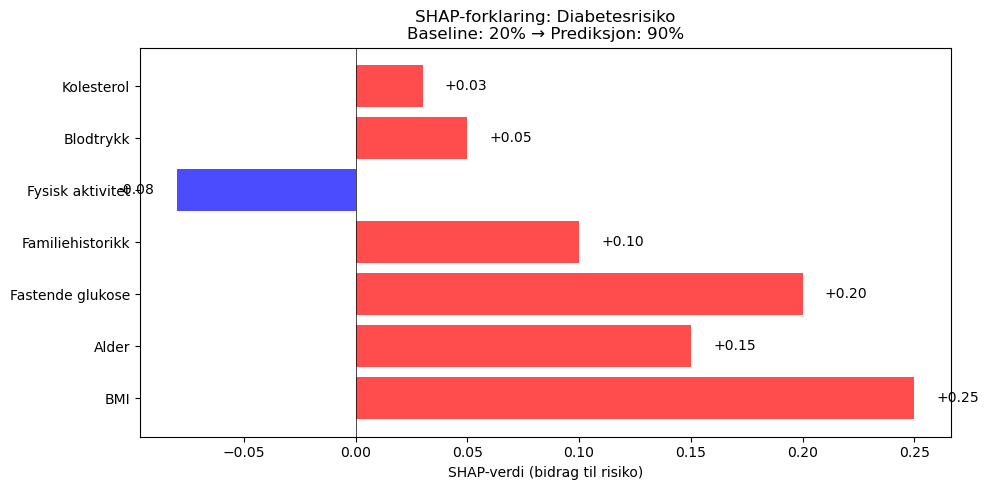


Tolkning for kliniker:
--------------------------------------------------
Denne pasienten har 90% risiko for diabetes (gjennomsnitt: 20%)

Hovedårsaker til økt risiko:
  - BMI: +0.25
  - Fastende glukose: +0.20
  - Alder: +0.15


In [3]:
# Simulert SHAP-forklaring for en diabetesrisiko-modell

def simuler_shap_forklaring():
    """
    Simulerer en SHAP-forklaring for demonstrasjon.
    I praksis ville vi brukt shap-biblioteket på en reell modell.
    """
    # Pasient med høy diabetesrisiko
    features = ['BMI', 'Alder', 'Fastende glukose', 'Familiehistorikk', 
                'Fysisk aktivitet', 'Blodtrykk', 'Kolesterol']
    
    # SHAP-verdier (simulert): positive = øker risiko, negative = reduserer
    shap_values = [0.25, 0.15, 0.20, 0.10, -0.08, 0.05, 0.03]
    
    # Baseline og prediksjon
    baseline = 0.20  # Gjennomsnittlig risiko i populasjonen
    prediction = baseline + sum(shap_values)  # 0.90
    
    return features, shap_values, baseline, prediction

features, shap_values, baseline, prediction = simuler_shap_forklaring()

# Visualiser SHAP-verdier
fig, ax = plt.subplots(figsize=(10, 5))

colors = ['red' if v > 0 else 'blue' for v in shap_values]
y_pos = range(len(features))

ax.barh(y_pos, shap_values, color=colors, alpha=0.7)
ax.set_yticks(y_pos)
ax.set_yticklabels(features)
ax.set_xlabel('SHAP-verdi (bidrag til risiko)')
ax.set_title(f'SHAP-forklaring: Diabetesrisiko\nBaseline: {baseline:.0%} → Prediksjon: {prediction:.0%}')
ax.axvline(x=0, color='black', linewidth=0.5)

# Legg til verdier på søylene
for i, (feature, value) in enumerate(zip(features, shap_values)):
    ax.text(value + 0.01 if value > 0 else value - 0.01, i, 
            f'{value:+.2f}', va='center', 
            ha='left' if value > 0 else 'right')

plt.tight_layout()
plt.show()

print("\nTolkning for kliniker:")
print("-" * 50)
print(f"Denne pasienten har {prediction:.0%} risiko for diabetes (gjennomsnitt: {baseline:.0%})")
print("\nHovedårsaker til økt risiko:")
for f, v in sorted(zip(features, shap_values), key=lambda x: x[1], reverse=True)[:3]:
    print(f"  - {f}: {v:+.2f}")

### Fordeler og ulemper med SHAP

| Fordeler | Ulemper |
|----------|----------|
| Teoretisk fundament (Shapley) | Kan være beregningsmessig krevende |
| Konsistent og rettferdig | Forklaringer kan være vanskelige å tolke |
| Fungerer for alle modelltyper | Krever tilgang til treningsdata |

---

## 4. LIME - Local Interpretable Model-agnostic Explanations

LIME forklarer enkeltstående prediksjoner ved å bygge en enkel, tolkbar modell lokalt rundt prediksjonen.

### Hvordan LIME fungerer

1. Generer perturberte versjoner av input (med små endringer)
2. Få prediksjoner for alle perturberte versjoner
3. Tren en enkel modell (f.eks. lineær) på disse
4. Bruk den enkle modellen til å forklare

LIME-forklaring for tekstklassifisering
Tekst: 'Pasienten har brystsmerter og kortpustethet ved anstrengelse'
Klassifisering: Hjertesykdom (sannsynlighet: 85%)

Ord som bidrar til klassifiseringen:
  brystsmerter    ███████ (+0.35)
  kortpustethet   █████ (+0.25)
  anstrengelse    ███ (+0.15)


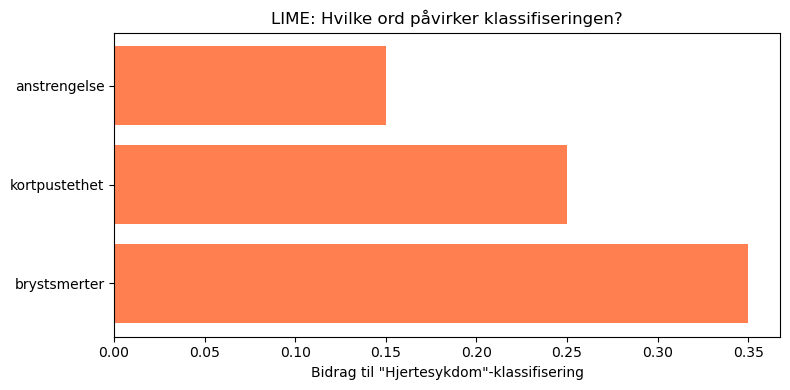

In [4]:
# Simulert LIME-forklaring for tekstklassifisering

def simuler_lime_tekstforklaring():
    """
    Simulerer en LIME-forklaring for en medisinsk tekstklassifisering.
    """
    tekst = "Pasienten har brystsmerter og kortpustethet ved anstrengelse"
    
    # Simulerte ord-bidrag til klassifiseringen "Hjertesykdom"
    ord_bidrag = {
        'brystsmerter': 0.35,
        'kortpustethet': 0.25,
        'anstrengelse': 0.15,
        'Pasienten': 0.0,
        'har': 0.0,
        'og': 0.0,
        'ved': 0.0
    }
    
    return tekst, ord_bidrag

tekst, ord_bidrag = simuler_lime_tekstforklaring()

print("LIME-forklaring for tekstklassifisering")
print("=" * 50)
print(f"Tekst: '{tekst}'")
print(f"Klassifisering: Hjertesykdom (sannsynlighet: 85%)")
print()
print("Ord som bidrar til klassifiseringen:")
for ord, bidrag in sorted(ord_bidrag.items(), key=lambda x: x[1], reverse=True):
    if bidrag > 0:
        bar = '█' * int(bidrag * 20)
        print(f"  {ord:15s} {bar} ({bidrag:+.2f})")

# Visualiser
viktige_ord = [(k, v) for k, v in ord_bidrag.items() if v > 0]
ord, verdier = zip(*viktige_ord)

fig, ax = plt.subplots(figsize=(8, 4))
ax.barh(ord, verdier, color='coral')
ax.set_xlabel('Bidrag til "Hjertesykdom"-klassifisering')
ax.set_title('LIME: Hvilke ord påvirker klassifiseringen?')
plt.tight_layout()
plt.show()

---

## 5. Attention-baserte forklaringer

For transformer-modeller som LLM-er kan vi visualisere **attention-vektene** for å se hva modellen "fokuserer" på.

### Viktig forbehold

Attention er *ikke* det samme som forklaring! Forskning viser at:
- Høy attention betyr ikke nødvendigvis kausal påvirkning
- Samme prediksjon kan ha ulike attention-mønstre
- Attention kan være misvisende

Men det kan likevel gi nyttig innsikt som utgangspunkt for videre analyse.

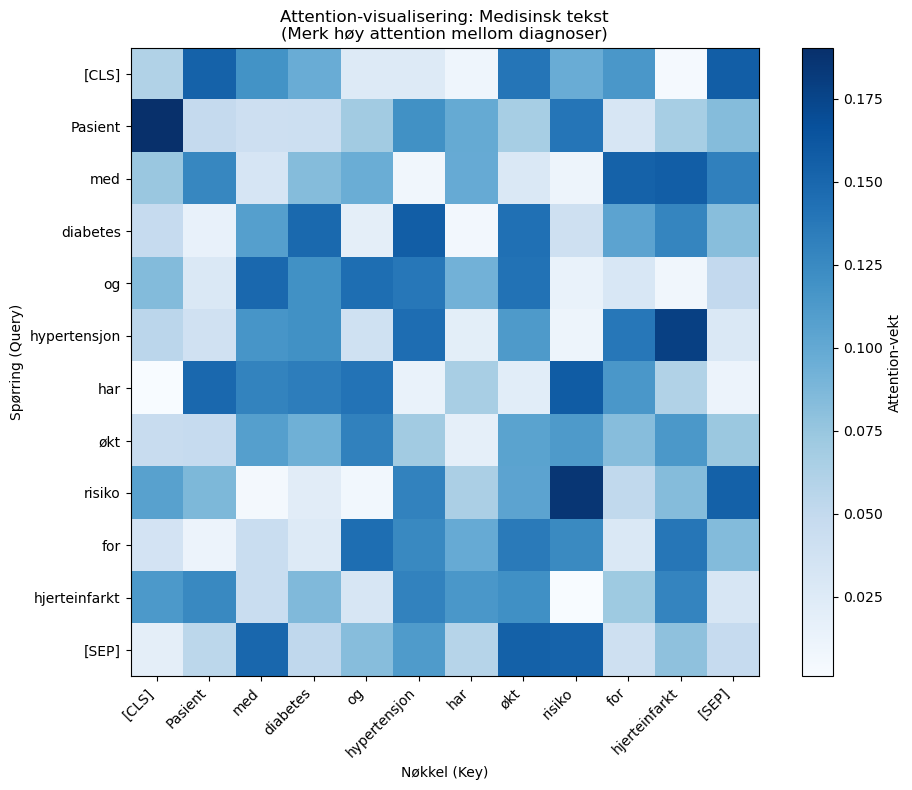

Observasjon:
Modellen viser høy attention mellom 'diabetes', 'hypertensjon' og 'hjerteinfarkt',
noe som indikerer at den har lært sammenhengen mellom disse diagnosene.


In [5]:
# Simulert attention-visualisering

import matplotlib.pyplot as plt
import numpy as np

def visualiser_attention_medisinsk():
    """Simuler attention for en medisinsk setning."""
    
    tokens = ['[CLS]', 'Pasient', 'med', 'diabetes', 'og', 'hypertensjon', 
              'har', 'økt', 'risiko', 'for', 'hjerteinfarkt', '[SEP]']
    
    # Simulert attention-matrise (12x12)
    np.random.seed(42)
    attention = np.random.rand(len(tokens), len(tokens))
    
    # Gjør attention mer realistisk: sykdommer bør ha høy attention til hverandre
    sykdom_idx = [3, 5, 10]  # diabetes, hypertensjon, hjerteinfarkt
    for i in sykdom_idx:
        for j in sykdom_idx:
            attention[i, j] += 0.5
    
    # Normaliser
    attention = attention / attention.sum(axis=1, keepdims=True)
    
    return tokens, attention

tokens, attention = visualiser_attention_medisinsk()

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(attention, cmap='Blues')

ax.set_xticks(range(len(tokens)))
ax.set_yticks(range(len(tokens)))
ax.set_xticklabels(tokens, rotation=45, ha='right')
ax.set_yticklabels(tokens)

ax.set_xlabel('Nøkkel (Key)')
ax.set_ylabel('Spørring (Query)')
ax.set_title('Attention-visualisering: Medisinsk tekst\n(Merk høy attention mellom diagnoser)')

plt.colorbar(im, label='Attention-vekt')
plt.tight_layout()
plt.show()

print("Observasjon:")
print("Modellen viser høy attention mellom 'diabetes', 'hypertensjon' og 'hjerteinfarkt',")
print("noe som indikerer at den har lært sammenhengen mellom disse diagnosene.")

---

## 6. Kliniske krav og utfordringer

### Hva trenger klinikere?

Forskning viser at leger ønsker forklaringer som er:

1. **Korte og presise** - ikke lange tekniske utredninger
2. **Klinisk relevante** - relatert til kjente risikofaktorer
3. **Handlebare** - gir grunnlag for å ta beslutninger
4. **Ærlige om usikkerhet** - ikke overselger modellens sikkerhet

### EU AI Act og forklarbarhet

Under EUs AI-forordning klassifiseres medisinsk AI ofte som **høyrisiko**, noe som krever:

- Dokumentasjon av hvordan modellen fungerer
- Mulighet for menneskelig overstyring
- Logging av beslutninger
- Forklaringer tilpasset brukerne

In [6]:
# Eksempel: Klinisk-vennlig forklaring

def generer_klinisk_forklaring(pasient, risiko, faktorer):
    """
    Genererer en kliniker-vennlig forklaring for en risikovurdering.
    """
    forklaring = f"""
╔══════════════════════════════════════════════════════════════╗
║  AI-STØTTET RISIKOVURDERING                                  ║
╚══════════════════════════════════════════════════════════════╝

PASIENT: {pasient['id']}
VURDERING: {risiko['kategori']} ({risiko['score']:.0%})

HOVEDFAKTORER (fra AI-analyse):
"""
    for i, (faktor, bidrag, retning) in enumerate(faktorer, 1):
        pil = "↑" if retning == 'øker' else "↓"
        forklaring += f"  {i}. {faktor} {pil} ({bidrag})\n"
    
    forklaring += f"""
USIKKERHET: Modellen er {risiko['konfidens']}% sikker på denne vurderingen.

⚠️  VIKTIG: Dette er beslutningsstøtte, ikke en diagnose.
    Klinisk vurdering er alltid påkrevd.
"""
    return forklaring

# Test
pasient = {'id': 'P-2024-001'}
risiko = {'kategori': 'Høy risiko', 'score': 0.78, 'konfidens': 85}
faktorer = [
    ('Alder over 65 år', '+15%', 'øker'),
    ('Diabetes type 2', '+12%', 'øker'),
    ('Aktiv røyker', '+18%', 'øker'),
    ('Regelmessig mosjon', '-8%', 'reduserer')
]

print(generer_klinisk_forklaring(pasient, risiko, faktorer))


╔══════════════════════════════════════════════════════════════╗
║  AI-STØTTET RISIKOVURDERING                                  ║
╚══════════════════════════════════════════════════════════════╝

PASIENT: P-2024-001
VURDERING: Høy risiko (78%)

HOVEDFAKTORER (fra AI-analyse):
  1. Alder over 65 år ↑ (+15%)
  2. Diabetes type 2 ↑ (+12%)
  3. Aktiv røyker ↑ (+18%)
  4. Regelmessig mosjon ↓ (-8%)

USIKKERHET: Modellen er 85% sikker på denne vurderingen.

⚠️  VIKTIG: Dette er beslutningsstøtte, ikke en diagnose.
    Klinisk vurdering er alltid påkrevd.



---

## Oppsummering

### Hovedpunkter

1. **Forklarbarhet er kritisk** i medisinsk AI for tillit, ansvar og regulering
2. **SHAP** gir teoretisk funderte forklaringer basert på spillteori
3. **LIME** bygger lokale tolkbare modeller rundt prediksjoner
4. **Attention** kan gi innsikt, men er ikke det samme som kausal forklaring
5. **Kliniske forklaringer** må være korte, relevante og handlingsbare

### Refleksjonsoppgaver

1. Når ville du foretrukket SHAP over LIME, og omvendt?
2. Hvordan ville du forklart en AI-risikovurdering til en pasient vs. en lege?
3. Hvilke etiske utfordringer ser du med å bruke AI uten god forklarbarhet?

---

*Neste notebook: [06 - AI-etikk i medisin](06-ai-etikk-medisin.ipynb)*